In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import random
import torch
import time
import numpy as np
from gensim.models.word2vec import Word2Vec
from model import BatchProgramClassifier
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

import re

from pycparser.c_ast import TypeDecl, ArrayDecl
from pycparser import c_ast

In [2]:
root = '/home/david/projects/university/astnn/data/'

word2vec = Word2Vec.load(root+"train/embedding/node_w2v_128").wv
embeddings = np.zeros((word2vec.vectors.shape[0] + 1, word2vec.vectors.shape[1]), dtype="float32")
embeddings[:word2vec.vectors.shape[0]] = word2vec.vectors

HIDDEN_DIM = 100
ENCODE_DIM = 128
LABELS = 104
EPOCHS = 15
BATCH_SIZE = 1
USE_GPU = False
MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]

model = BatchProgramClassifier(EMBEDDING_DIM,HIDDEN_DIM,MAX_TOKENS+1,ENCODE_DIM,LABELS,BATCH_SIZE,
                               USE_GPU, embeddings)
model.load_state_dict(torch.load("/home/david/projects/university/astnn/model.pt"))

<All keys matched successfully>

# Load Data

In [3]:
word2vec = Word2Vec.load('/home/david/projects/university/astnn/data/train/embedding/node_w2v_128').wv
vocab = word2vec.vocab

ast_data = pd.read_pickle(root+'test/test_.pkl')
block_data = pd.read_pickle(root+'test/blocks.pkl')

# Allowed var names

In [4]:
leaf_embed = nn.Sequential(
    model._modules['encoder']._modules['embedding'],
    model._modules['encoder']._modules['W_c']
)

In [5]:
# words we wont allow as variable names
reserved_words = [
    'auto',
    'break',
    'case',
    'char',
    'const',
    'continue',
    'default',
    'do',
    'int',
    'long',
    'register',
    'return',
    'short',
    'sizeof',
    'static',
    'struct',
    'switch',
    'typedef',
    'union',
    'unsigned',
    'void',
    'volatile',
    'while',
    'double',
    'else',
    'enum',
    'extern',
    'float',
    'for',
    'goto',
    'if',
    'printf',
    'scanf',
    'cos',
    'malloc'
]


def allowed_variable(var):
    pattern = re.compile("([a-z]|[A-Z]|_)+([a-z]|[A-Z]|[0-9]|_)*$")
    if (var not in reserved_words) and pattern.match(var):
        return True
    else:
        return False

allowed_variable('scanf')

False

In [6]:
embedding_map = {}

for index in range(len(vocab)):
    if allowed_variable(word2vec.index2word[index]):
        embedding_map[index] = leaf_embed(torch.tensor(index)).detach().numpy()

# Var insert functions

In [7]:
x = block_data['code'][45281]
x

[[32, [2, [30, [40, [4]]]]],
 [6],
 [2, [13, [4]]],
 [2, [22, [4]]],
 [2, [23, [24, [4]], [92]]],
 [2, [0, [4]]],
 [2, [8, [4]]],
 [11, [36], [12, [156], [29, [13]], [29, [22]]]],
 [16, [3, [0], [5]], [20, [0], [13]], [14, [0]]],
 [11, [36], [12, [46], [29, [1, [24], [0]]]]],
 [16, [3, [0], [5]], [20, [0], [13]], [14, [0]]],
 [6],
 [16, [3, [8], [17, [0], [10]]], [20, [8], [13]], [14, [8]]],
 [15, [19, [17, [1, [24], [0]], [1, [24], [8]]], [22]]],
 [52],
 [15, [44, [8], [13]]],
 [52],
 [7],
 [15, [19, [0], [13]]],
 [11, [25], [12, [196]]],
 [11, [25], [12, [279]]],
 [39, [5]],
 [7]]

In [8]:
len(x)

23

In [9]:
max_token = word2vec.vectors.shape[0]
max_token

8188

In [10]:
# x = insert_decl(x, 0)


In [11]:
loss_function = torch.nn.CrossEntropyLoss()

labels = torch.LongTensor([2])
output = model([x])
loss = loss_function(output, Variable(labels))
loss.backward()

In [12]:
n_list = model._modules['encoder'].node_list
n_list.size()

print(n_list[:, 0, :])
# print(n_list[:, 3, 0])

tensor([[ 8.8625e-02,  3.3421e-01, -3.9132e-02,  ...,  1.5931e-02,
         -4.7732e-02,  8.0548e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.0739e-01,  7.4652e-01, -2.6068e-01,  ...,  1.7443e-04,
          3.2481e-02,  1.6038e-01],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.8319e-01,  1.5429e+00, -6.5999e-01,  ...,  2.1027e-01,
          4.2654e-02,  1.8223e-01]], grad_fn=<SliceBackward>)


In [13]:
# l = [1, 2, 3]
# l.insert(0, 4)
# l

In [14]:
import random

def insert_decl(x, pos):
    insert_decl = [2, [8188, [4]]]
#     x.insert(random.randint(0,len(x)), insert_decl)
    x.insert(pos, insert_decl)
    return x

# Var replace functions

In [15]:
def replace_index(node, old_i, new_i):
    i = node[0]
    if i == old_i:
        result = [new_i]
    else:
        result = [i]
    children = node[1:]
    for child in children:
        result.append(replace_index(child, old_i, new_i))
    return result

def replace_var(x, old_i, new_i):
    mod_blocks = []
    for block in x:
        mod_blocks.append(replace_index(block, old_i, new_i))

    return mod_blocks

# Closest Var functions

In [16]:
def l2_norm(a, b):
    return np.linalg.norm(a-b)

def cos_sim(a, b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def closest_index(embedding, embedding_map, metric):
    closest_i = 0
#     closest_dist = l2_norm(embedding_map[closest_i], embedding)
    closest_dist = metric(embedding_map[closest_i], embedding)
    for i, e in embedding_map.items():
#         d = l2_norm(embedding_map[i], embedding)
        d = metric(embedding_map[i], embedding)
        if d < closest_dist:
            closest_dist = d
            closest_i = i
    return closest_i

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

# Grad locating functions

In [17]:
def get_embedding(indices, node_list):
    '''
    get the embeddings at the index positions in postorder traversal.
    '''
    res = []
    c = 0
    for i in range(node_list.size(0)):
        if not np.all(node_list[i].detach().numpy() == 0):
            if c in indices:
                res.append(node_list[i])
            c += 1
    return res

def post_order_loc(node, var, res, counter):
    '''
    
    '''
    index = node[0]
    children = node[1:]
    for child in children:
        res, counter = post_order_loc(child, var, res, counter)
    if var == index and (not children):
        res.append(counter) 
#         print(counter, word2vec.index2word[index])
    counter += 1
    return res, counter

def get_grad(x, var_index, node_list):
    grads = []
    for i, block in enumerate(x):
        indices, _ = post_order_loc(block, var_index, [], 0)
        grads += get_embedding(indices, node_list.grad[:, i, :])
        try:
            node_embedding = get_embedding(indices, node_list[:, i, :])[0]
        except Exception as e:
            pass
        
    if len(grads) < 1:
        return None, None
    grad = torch.stack(grads).sum(dim=0)
    return grad, node_embedding

# Var name finder

In [18]:

class declarationFinder(c_ast.NodeVisitor):
    def __init__(self):
        self.names = set()
    
    def visit_Decl(self, node):
        if type(node.type) in [TypeDecl, ArrayDecl] :
            self.names.add(node.name)

def get_var_names(ast):
    declaration_finder = declarationFinder()
    declaration_finder.visit(ast)
    return declaration_finder.names
    
# get_var_names(x)

# FGSM

In [19]:
def gradient_method(x, n_list, epsilon, metric):

    orig_index = MAX_TOKEN

    grad, node_embedding = get_grad(x, orig_index, n_list)
    if grad is None:
#         print("no leaf occurences")
        return None

    v = node_embedding.detach().numpy()
    g = torch.sign(grad).detach().numpy()

    v = v + epsilon * g
    # get the closest emebedding from our map
    i = closest_index(v, embedding_map, metric)
#         print("orig name:", word2vec.index2word[orig_index], "; new name:", word2vec.index2word[i])
    if i != orig_index:
        return replace_var(x, orig_index, i)
    else:
        return x

In [20]:
MAX_TOKEN = word2vec.vectors.shape[0]

# x, ast = block_data['code'][45281], ast_data['code'][45281]

# _, orig_pred = torch.max(model([x]).data, 1)
# orig_pred = orig_pred.item()

# # get the grad
# loss_function = torch.nn.CrossEntropyLoss()
# labels = torch.LongTensor([orig_pred])
# output = model([x])
# loss = loss_function(output, Variable(labels))
# loss.backward()
# n_list = model._modules['encoder'].node_list

# new_x_l2 = gradient_method(x, n_list, 1, l2_norm)

# o = model([new_x_l2])
# _, predicted_l2 = torch.max(o.data, 1)

# print(orig_pred, predicted_l2.item())

In [21]:
def evaluate(epsilon, limit = None):
    ast_count = 0
    pos_count = 0

    ast_total = 0
    pos_total = 0

    for code_id in block_data['id'].tolist():
    #     print(code_id)
        x, ast = block_data['code'][code_id], ast_data['code'][code_id]

        _, orig_pred = torch.max(model([x]).data, 1)
        orig_pred = orig_pred.item()


#         var_names = get_var_names(ast)
        success = False

        for pos in range(len(x)):
            new_x = insert_decl(x, pos)
                    # get the grad
            loss_function = torch.nn.CrossEntropyLoss()
            labels = torch.LongTensor([orig_pred])
            output = model([new_x])
            loss = loss_function(output, Variable(labels))
            loss.backward()
            n_list = model._modules['encoder'].node_list

            new_x_l2 = gradient_method(new_x, n_list, epsilon, l2_norm)
        
            if new_x_l2:
                o = model([new_x_l2])
                _, predicted_l2 = torch.max(o.data, 1)

                if orig_pred != predicted_l2.item():
                    success = True
                    pos_count += 1
            pos_total += 1
                
        if success:
            ast_count += 1
        ast_total += 1
        


#         if ast_total % 10 == 9:
        print(ast_total, "AST level success:", ast_total, ast_count / ast_total)
        print("position level success:", pos_total, pos_count / pos_total)
    
        if limit and limit < ast_total:
            break
    return (1-(ast_count / ast_total), 1-(pos_count / pos_total))



In [22]:
evaluate(40, limit=500)

1 AST level success: 1 0.0
position level success: 23 0.0
2 AST level success: 2 0.0
position level success: 54 0.0
3 AST level success: 3 0.0
position level success: 85 0.0
4 AST level success: 4 0.0
position level success: 125 0.0
5 AST level success: 5 0.0
position level success: 150 0.0
6 AST level success: 6 0.0
position level success: 192 0.0
7 AST level success: 7 0.0
position level success: 224 0.0
8 AST level success: 8 0.0
position level success: 266 0.0
9 AST level success: 9 0.0
position level success: 305 0.0
10 AST level success: 10 0.0
position level success: 342 0.0
11 AST level success: 11 0.0
position level success: 367 0.0
12 AST level success: 12 0.0
position level success: 397 0.0
13 AST level success: 13 0.0
position level success: 443 0.0
14 AST level success: 14 0.0
position level success: 477 0.0
15 AST level success: 15 0.0
position level success: 505 0.0
16 AST level success: 16 0.0
position level success: 564 0.0
17 AST level success: 17 0.0
position level s

100 AST level success: 100 0.04
position level success: 4190 0.03174224343675418
101 AST level success: 101 0.039603960396039604
position level success: 4230 0.03144208037825059
102 AST level success: 102 0.0392156862745098
position level success: 4263 0.031198686371100164
103 AST level success: 103 0.038834951456310676
position level success: 4300 0.030930232558139537
104 AST level success: 104 0.038461538461538464
position level success: 4367 0.030455690405312572
105 AST level success: 105 0.0380952380952381
position level success: 4411 0.030151892994785764
106 AST level success: 106 0.03773584905660377
position level success: 4447 0.02990780301326737
107 AST level success: 107 0.037383177570093455
position level success: 4507 0.029509651652984248
108 AST level success: 108 0.037037037037037035
position level success: 4528 0.02937279151943463
109 AST level success: 109 0.03669724770642202
position level success: 4567 0.029121961900591197
110 AST level success: 110 0.03636363636363636

186 AST level success: 186 0.03225806451612903
position level success: 7641 0.02067792173799241
187 AST level success: 187 0.03208556149732621
position level success: 7671 0.0205970538391344
188 AST level success: 188 0.031914893617021274
position level success: 7701 0.020516815997922346
189 AST level success: 189 0.031746031746031744
position level success: 7769 0.020337237739734844
190 AST level success: 190 0.031578947368421054
position level success: 7787 0.020290227301913447
191 AST level success: 191 0.031413612565445025
position level success: 7891 0.020022810797110633
192 AST level success: 192 0.03125
position level success: 7916 0.01995957554320364
193 AST level success: 193 0.031088082901554404
position level success: 7958 0.01985423473234481
194 AST level success: 194 0.03608247422680412
position level success: 7994 0.023892919689767325
195 AST level success: 195 0.041025641025641026
position level success: 8027 0.02628628379220132
196 AST level success: 196 0.0408163265306

272 AST level success: 272 0.04044117647058824
position level success: 10915 0.025194686211635363
273 AST level success: 273 0.040293040293040296
position level success: 10960 0.02509124087591241
274 AST level success: 274 0.040145985401459854
position level success: 10998 0.025004546281142025
275 AST level success: 275 0.04
position level success: 11020 0.0249546279491833
276 AST level success: 276 0.03985507246376811
position level success: 11275 0.024390243902439025
277 AST level success: 277 0.039711191335740074
position level success: 11317 0.024299726075815146
278 AST level success: 278 0.039568345323741004
position level success: 11384 0.02415671117357695
279 AST level success: 279 0.03942652329749104
position level success: 11429 0.02406159769008662
280 AST level success: 280 0.039285714285714285
position level success: 11477 0.02396096540907903
281 AST level success: 281 0.03914590747330961
position level success: 11494 0.023925526361579956
282 AST level success: 282 0.0390070

357 AST level success: 357 0.03361344537815126
position level success: 14794 0.01872380694876301
358 AST level success: 358 0.0335195530726257
position level success: 14827 0.018682133944830377
359 AST level success: 359 0.033426183844011144
position level success: 14863 0.01863688353629819
360 AST level success: 360 0.03333333333333333
position level success: 14885 0.018609338259993283
361 AST level success: 361 0.0332409972299169
position level success: 14946 0.018533386859360363
362 AST level success: 362 0.03314917127071823
position level success: 15013 0.018450676080730033
363 AST level success: 363 0.03305785123966942
position level success: 15045 0.018411432369557994
364 AST level success: 364 0.03296703296703297
position level success: 15084 0.018363829223017766
365 AST level success: 365 0.03287671232876712
position level success: 15115 0.018326166060205096
366 AST level success: 366 0.03278688524590164
position level success: 15151 0.01828262160913471
367 AST level success: 3

441 AST level success: 441 0.02947845804988662
position level success: 18120 0.016556291390728478
442 AST level success: 442 0.029411764705882353
position level success: 18148 0.016530747189772977
443 AST level success: 443 0.029345372460496615
position level success: 18177 0.01650437365901964
444 AST level success: 444 0.02927927927927928
position level success: 18226 0.01646000219466696
445 AST level success: 445 0.029213483146067417
position level success: 18270 0.016420361247947456
446 AST level success: 446 0.02914798206278027
position level success: 18300 0.01639344262295082
447 AST level success: 447 0.029082774049217
position level success: 18316 0.016379122079056563
448 AST level success: 448 0.029017857142857144
position level success: 18390 0.01631321370309951
449 AST level success: 449 0.028953229398663696
position level success: 18419 0.016287529181823118
450 AST level success: 450 0.028888888888888888
position level success: 18444 0.01626545217957059
451 AST level success

(0.9700598802395209, 0.9813912272928667)

In [31]:
# _, orig_pred = torch.max(model([x]).data, 1)
# orig_pred = orig_pred.item()

# loss_function = torch.nn.CrossEntropyLoss()
# labels = torch.LongTensor([orig_pred])
# output = model([x])
# loss = loss_function(output, Variable(labels))
# loss.backward()
# n_list = model._modules['encoder'].node_list
# # n_list

In [15]:
import time

epsilons = np.linspace(1,100,50)
ast_performances = []
var_performances = []
for e in epsilons:
    start = time.time()
    ast_performance, var_performance = evaluate(e, limit=500)
    eval_time = time.time() - start
    
    ast_performances.append(ast_performance)
    var_performances.append(var_performance)
    print(e, eval_time, ast_performance, var_performance)

1.0 316.8549587726593 0.7025948103792415 0.9131382316313823
3.020408163265306 323.2173819541931 0.5948103792415169 0.8667496886674969
5.040816326530612 325.6832218170166 0.5548902195608783 0.8552303860523038
7.061224489795918 323.04881858825684 0.5349301397205588 0.8490037359900373
9.081632653061224 409.30822825431824 0.5289421157684631 0.8474470734744708
11.102040816326529 420.1697244644165 0.5229540918163673 0.8443337484433375
13.122448979591836 339.04012799263 0.5209580838323353 0.8427770859277709
15.142857142857142 320.73645424842834 0.5209580838323353 0.8412204234122043
17.163265306122447 325.44847297668457 0.5209580838323353 0.8412204234122043
19.183673469387752 342.023814201355 0.5189620758483033 0.8402864259028643
21.204081632653057 348.2508633136749 0.5189620758483033 0.8402864259028643
23.224489795918366 395.9612376689911 0.5189620758483033 0.8405977584059776
25.24489795918367 408.7793822288513 0.5189620758483033 0.8402864259028643
27.265306122448976 376.29552721977234 0.5189

KeyboardInterrupt: 

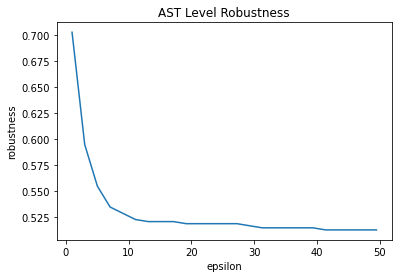

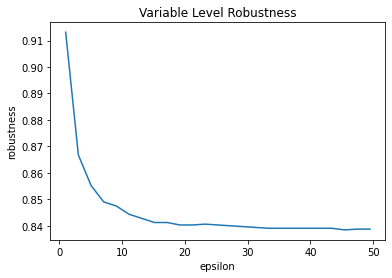

In [20]:
import matplotlib.pyplot as plt

plt.plot(epsilons[:25], ast_performances)
plt.xlabel("epsilon")
plt.ylabel("robustness")
plt.title("AST Level Robustness")
plt.show()

plt.plot(epsilons[:25], var_performances)
plt.xlabel("epsilon")
plt.ylabel("robustness")
plt.title("Variable Level Robustness")
plt.show()

In [17]:
len(var_performances)

25

In [23]:
ast_performances[:-1]

[0.7025948103792415,
 0.5948103792415169,
 0.5548902195608783,
 0.5349301397205588,
 0.5289421157684631,
 0.5229540918163673,
 0.5209580838323353,
 0.5209580838323353,
 0.5209580838323353,
 0.5189620758483033,
 0.5189620758483033,
 0.5189620758483033,
 0.5189620758483033,
 0.5189620758483033,
 0.5169660678642715,
 0.5149700598802396,
 0.5149700598802396,
 0.5149700598802396,
 0.5149700598802396,
 0.5149700598802396,
 0.5129740518962076,
 0.5129740518962076,
 0.5129740518962076,
 0.5129740518962076]

In [22]:
var_performances

[0.9131382316313823,
 0.8667496886674969,
 0.8552303860523038,
 0.8490037359900373,
 0.8474470734744708,
 0.8443337484433375,
 0.8427770859277709,
 0.8412204234122043,
 0.8412204234122043,
 0.8402864259028643,
 0.8402864259028643,
 0.8405977584059776,
 0.8402864259028643,
 0.839975093399751,
 0.8396637608966376,
 0.8393524283935243,
 0.839041095890411,
 0.839041095890411,
 0.839041095890411,
 0.839041095890411,
 0.839041095890411,
 0.839041095890411,
 0.8384184308841843,
 0.8387297633872977,
 0.8387297633872977]